# Training a Segmentation Model
In this Notebook, we'll do the following.

* Install the `mmdetection` package
* Setup a configuration files to use our custom dataset for training and inference
* Visualize training progress
* Save our trained model to use for inference later
* Make inference with our trained model

__NOTE:__ This notebook will be a bit different from the previous ones. Rather than executing Python code, we'll be installing and running python scripts already defined in the _mmdetection_ codebase.

# Requirements
* Linux or macOS (Windows is not currently officially supported)
* The `wacv_demo` conda environment we've been using. Make sure your Jupyter notebook is using this environment


## Installing mmdetection
Execute the cell below to install all of the dependencies one-by-one. If you have already executed these in a terminal within the `wacv_demo` conda environment, you do not have to repeat them.

These are the same steps as outline in the Chapter 3 [README](https://github.com/mosdragon/kdd2020/blob/master/tutorial/Chapter-3-Training-Segmentation-Models/README.md).

__NOTE:__ If you have a CUDA-enabled machine, follow this [guide](https://github.com/open-mmlab/mmdetection/blob/master/docs/install.md) for instructions on installing PyTroch and Torchvision. 

In [ ]:
!conda install -y pytorch torchvision -c pytorch
!pip install -U "git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools"
!pip install mmcv-full
!pip install seaborn
!pip install torch

## Changing Directory
All of the mmdetection files are in the `mmdetection` folder. We need to change directory into that folder so we can execute the training code. Run the cell below on each run:

In [ ]:
%cd mmdetection
!pip install -v -e .

## Sanity Check
Ensure that you're in the `mmdetection` directory now by running `%pwd` in the next notebook cell.

In [4]:
%pwd

'/home/mxs8x15/code/kdd2020/tutorial/Chapter-3-Training-Segmentation-Models/mmdetection'

# MMDetection Data and Configuration Files
For _mmdetection_ to work properly, we need to create several data and configuration files. We've created them for you here, but if you use a different dataset (i.e. you generate a new dataset from Chapter 2 with different scenes or labels), you'll have to make these changes on your own. Here, we'll show which files we changed and give guidance on how you can do the same.

## MMdetection Dataset Files

For _mmdetection_ to work properly, we need to create several data and configuration files. We've created them for you here, but if you use a different dataset (i.e. you generate a new dataset from Chapter 2 with different scenes or labels), you'll have to create/change the following files:

* `mmdetection/mmdet/datasets/ade20kbed.py`: This file inhereits from the `CocoDataset` file, which specifies how _mmdetection_ should read COCO-formatted datasets. For our purposes, we just placed the following in this file:


```python
from .coco import CocoDataset
from .builder import DATASETS

@DATASETS.register_module()
class Ade20kBed(CocoDataset):
    CLASSES = ('door | doorframe, doorcase | double door', 'bed | bedpost | blanket, cover | headboard', 'wardrobe, closet, press', 'lamp', 'chest of drawers, chest, bureau, dresser | chest', 'pillow', 'armchair | chair | swivel    chair', 'pane, pane of glass, window glass | windowpane, window', 'curtain, drape, drapery, mantle, pall',          'mirror', 'painting, picture | frame', 'wall', 'ceiling', 'floor, flooring', 'cabinet')
    
```

<br/>

* `mmdetection/mmdet/datasets/__init__.py`: This file is a registry of all datasets your training/testing scripts may call on. Since we created a `dataset` in the file above, we need to add to this `__init__.py` file like so:

```python
from .ade20kbed import Ade20kBed
...
__all__ = [..., 'Ade20kBed']
```

## Config Files

__Note:__ There are many related files and dependencies in this section. It may be a bit difficult to understand all of these changes from this short description, so we encourage you to explore these files yourselves and to also check out the great [mmdetection documentation](https://github.com/open-mmlab/mmdetection/tree/master/docs/tutorials)

__Note:__ If you would rather skip the steps for modifying these config files yourself, you can also retrieve the modified files and replace the original ones directly using the following commands:
```
!wget https://storage.googleapis.com/kdd2020hdvisai/static/mmdet_configs/coco_detection.py -O configs/_base_/datasets/coco_detection.py
!wget https://storage.googleapis.com/kdd2020hdvisai/static/mmdet_configs/mask_rcnn_r50_fpn.py -O configs/_base_/models/mask_rcnn_r50_fpn.py
!wget https://storage.googleapis.com/kdd2020hdvisai/static/mmdet_configs/schedule_1x.py -O configs/_base_/schedules/schedule_1x.py
```

__Choosing a model to use:__ mmdetection's [Model Zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/model_zoo.md). For example, if we want to use [Res2Net](https://github.com/open-mmlab/mmdetection/tree/master/configs/res2net) as backbone, and [Mask-RCNN](https://github.com/open-mmlab/mmdetection/tree/master/configs/mask_rcnn) as our model.
<br />

It's possible that the desired combination of model and backbone's performance information be listed under either the backbone page or the model page. Here, it's listed under the [backbone page](https://github.com/open-mmlab/mmdetection/tree/master/configs/res2net) for Res2Net.
<br />

We note the mask AP (38.7) and find the corresponding config file: `configs/res2net/mask_rcnn_r2_101_fpn_2x_coco.py`
    
* __Configuring our model:__ We can go into our mmdetection `config` directory and modify the corresponding files. In the newest mmdetection release, the config files use wrappers so they are more structured.
<br />

We look at the config file and figure out which other files we need to modify. Usually, we need to modify 3 files:
* The base model config file
* The dataset config file
* The schedule file

In `configs/res2net/mask_rcnn_r2_101_fpn_2x_coco.py`, we see on the very top:
```python
_base_ = '../mask_rcnn/mask_rcnn_r50_fpn_2x_coco.py'
```
<br/>

 
When we open this file, we see the following:
```python
_base_ = [
    '../_base_/models/mask_rcnn_r50_fpn.py',
    '../_base_/datasets/coco_instance.py',
    '../_base_/schedules/schedule_2x.py',
    '../_base_/default_runtime.py',
]
```

These _base_ of these files are what we should modify. Here we modify:
`mask_rcnn_r50_fpn.py`, `schedule_1x.py` (the base schedule file for `schedule_2x.py`), and `coco_detection.py` (the base dataset config file for `coco_instance.py`):

* In `mask_rcnn_r50_fpn.py`, we modify all `num_classes` and set them to 15, corresponding to the number of unique object classes in our `bedroom_scenes_coco` dataset.
* In `schedule_2x.py`, assuming you have 1 gpu only, we modify lr to 1/8 of the default parameter (default based on 8 gpus), and `total_epochs` to set number of training epochs.
* In ```coco_detection.py```, we modify our ```data_root```, ```dataset_type```, and if needed, ```data = dict(...)``` where the files to our training/validation images and annotations are set. In the current version of the file, we've set the location to `data/bedroom_scenes_coco` because we're using a symlink at that location to point us back to `<PROJECT-ROOT>/datasets/bedroom_scenes_coco`, the location of the dataset from Chapter 2.

# Training

With these configuration files in place, we can finally begin training. For this training run, we will create a folder called `work_dirs/ade20k/short` and store our trained models there for use later. The `short` here refers to the number of epochs we're training for, which for this demo will be only `2`. For Chapter 4, we'll provide models you can store in `long` that have been trained for 2-6 hours.

Execute the cells below to get started:

In [10]:
# Create the work directories. We'll store models in the short directory.
%mkdir -p work_dirs/ade20k/short
%mkdir -p work_dirs/ade20k/long

In [18]:
# Run the training. There will be a lot of logs output here, we can
# ignore most of them. 
!python -u tools/train.py \
configs/res2net/mask_rcnn_r2_101_fpn_2x_coco.py \
--work-dir work_dirs/ade20k/short/

2020-07-24 17:51:37,996 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.7 (default, May  7 2020, 21:25:33) [GCC 7.3.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda-10.2
NVCC: Cuda compilation tools, release 10.2, V10.2.89
GPU 0: Tesla V100-SXM2-16GB
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.5.1
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-genco

/opt/miniconda3/envs/dexi2/lib/python3.7/site-packages/mmcv/utils/misc.py:256: UserWarning: "out_size" is deprecated in `RoIAlign.__init__`, please use "output_size" instead
  f'"{src_arg_name}" is deprecated in '
/opt/miniconda3/envs/dexi2/lib/python3.7/site-packages/mmcv/utils/misc.py:256: UserWarning: "sample_num" is deprecated in `RoIAlign.__init__`, please use "sampling_ratio" instead
  f'"{src_arg_name}" is deprecated in '
2020-07-24 17:51:39,091 - mmdet - INFO - load model from: open-mmlab://res2net101_v1d_26w_4s
2020-07-24 17:51:39,292 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
2020-07-24 17:51:42,406 - mmdet - INFO - Start running, host: mxs8x15@osama-cerberus, work_dir: /home/mxs8x15/code/kdd2020/tutorial/Chapter-3-Training-Se

2020-07-24 17:59:50,554 - mmdet - INFO - Epoch [1][840/840]	lr: 2.500e-03, bbox_mAP: 0.1180, bbox_mAP_50: 0.2680, bbox_mAP_75: 0.0840, bbox_mAP_s: 0.0490, bbox_mAP_m: 0.1250, bbox_mAP_l: 0.1250, bbox_mAP_copypaste: 0.118 0.268 0.084 0.049 0.125 0.125, segm_mAP: 0.0680, segm_mAP_50: 0.1750, segm_mAP_75: 0.0460, segm_mAP_s: 0.0190, segm_mAP_m: 0.0510, segm_mAP_l: 0.0770, segm_mAP_copypaste: 0.068 0.175 0.046 0.019 0.051 0.077
2020-07-24 18:00:13,388 - mmdet - INFO - Epoch [2][50/840]	lr: 2.500e-03, eta: 0:05:06, time: 0.457, data_time: 0.070, memory: 7399, loss_rpn_cls: 0.0801, loss_rpn_bbox: 0.1642, loss_cls: 0.4499, acc: 87.9355, loss_bbox: 0.4482, loss_mask: 0.4393, loss: 1.5818
2020-07-24 18:00:33,551 - mmdet - INFO - Epoch [2][100/840]	lr: 2.500e-03, eta: 0:04:47, time: 0.403, data_time: 0.024, memory: 7399, loss_rpn_cls: 0.0769, loss_rpn_bbox: 0.1648, loss_cls: 0.4864, acc: 87.3613, loss_bbox: 0.4741, loss_mask: 0.4481, loss: 1.6503
2020-07-24 18:00:53,749 - mmdet - INFO - Epoch [2

# Evaluation
MMDetection comes with some tools to analyze the logs, we can run them here
by providing the log file as an input. These plots can help us understand our model's performance over a long period of time.

Run the cell below to get the name of the JSON log file, then place that
filename in the following cell where indicated.

In [ ]:
# TODO: Copy the 20XXXXXX_XXXXXX.log.json filename in the output.
%ls work_dirs/ade20k/short | grep json

In [ ]:
# TODO: Copy the filename above, paste below in line 3 here.
!python tools/analyze_logs.py plot_curve \
work_dirs/ade20k/short/[FILENAME-ABOVE-GOES-HERE] \
--keys segm_mAP segm_mAP_50 segm_mAP_75 \
--out work_dirs/ade20k/short/loss_mask.png

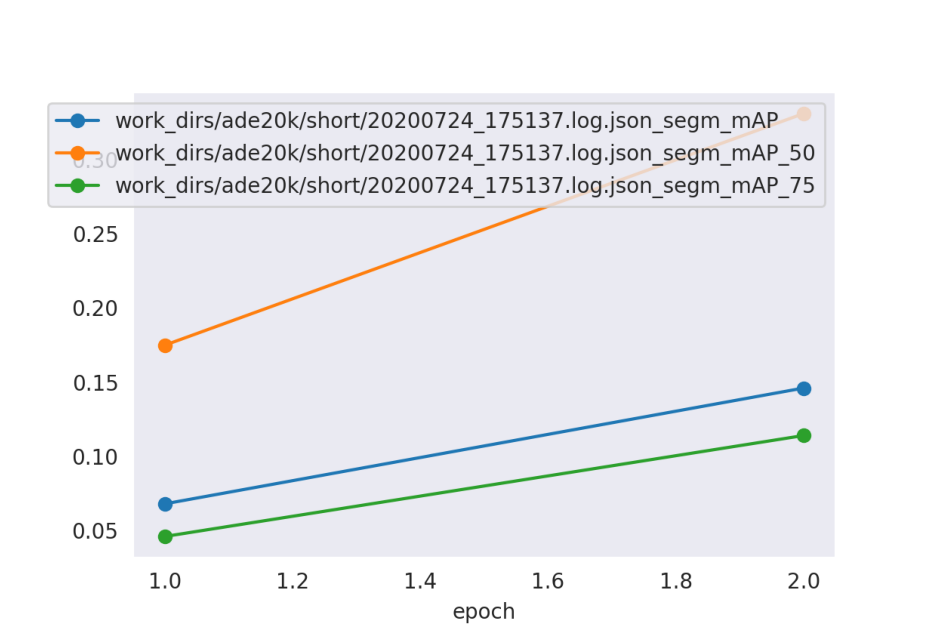

In [64]:
from imageio import imread
from matplotlib import pyplot as plt

img = imread("work_dirs/ade20k/short/loss_mask.png")

plt.figure(dpi=200)
plt.axis("off")
plt.imshow(img)

## Evaluating Our Best Model

If you followed the download steps in the README for Chapter 3, you'll now have the following in `mmdetection/work_dirs/ade20k/long`:
- `20200723_222335.log.json`
- `epoch_18.pth`

Here we'll generate the plot for the model we trained for 4-6 hours using our GPUs, which we've shared with you.

In [58]:
!python tools/analyze_logs.py plot_curve \
work_dirs/ade20k/long/20200723_222335.log.json \
--keys segm_mAP segm_mAP_50 segm_mAP_75 \
--out work_dirs/ade20k/long/loss_mask.png

plot curve of work_dirs/ade20k/long/20200723_222335.log.json, metric is segm_mAP
plot curve of work_dirs/ade20k/long/20200723_222335.log.json, metric is segm_mAP_50
plot curve of work_dirs/ade20k/long/20200723_222335.log.json, metric is segm_mAP_75
save curve to: work_dirs/ade20k/long/loss_mask.png


## Analyzing the Plot
Here you can see for the `long` training cycle, we get the model at peak mAP around `epoch=18`. For this reason, we shared `epoch_18.pth` as part of the downloads.

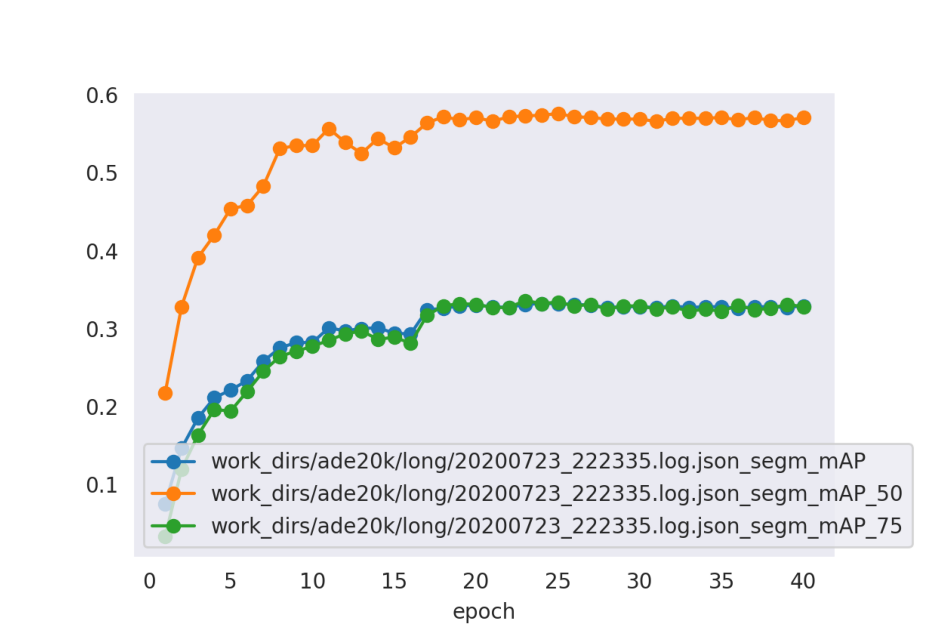

In [63]:
from imageio import imread
from matplotlib import pyplot as plt

img = imread("work_dirs/ade20k/long/loss_mask.png")

plt.figure(dpi=200)
plt.axis("off")
plt.imshow(img)